In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
import numpy as np

# Auswahl von Modellen
[Video](https://mstream.hm.edu/paella/ui/watch.html?id=15db674f-fa07-4980-b621-e088eeda7203)

**Zentrale Frage: Modell nicht gut genug — was ist zu tun?** 

Möglichkeiten: Verwende

-  komplexeres Modell
-  einfacheres Modell
-  mehr Trainingsdaten
-  andere Features

## Bias-Variance Trade-off:
Diesen Trade-off müssen wir beachten, wenn wir die **Komplexität des Modells** wählen.

Unter *Bias* versteht man die Einengung der Modellklasse. Optimalerweise sollte das geschehen anhand von starken Hypothesen. Das Modell wird damit gezwungen, sich gemäß dieser Hypothesen zu verhalten. Es hat somit weniger Freiheit.

Wir betrachten das anhand eines einfachen Beispiels mit zweidimensionalen (und damit leicht zu visualisierenden) Daten.

#### Definiere Funktionen, die Daten generieren und Modelle erstellen:

In [2]:
def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

#### Underfitting und Overfitting - Grafik

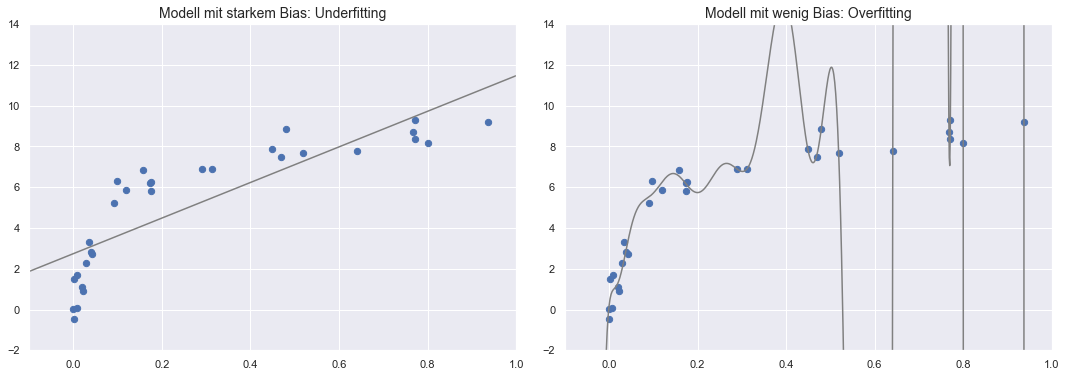

In [12]:
X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40)
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('Modell mit starkem Bias: Underfitting', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('Modell mit wenig Bias: Overfitting', size=14);

#### Underfitting und Overfitting - Beschreibung

**Underfitting:**
Das Modell mit starkem Bias muss sich innerhalb enger Grenzen bewegen
(hier: kann nur lineare Polynome wählen). Das führt dazu, dass das Modell die Daten nicht angemessen darstellen kann.

**Overfitting:**
Das Modell mit wenig Bias kann aus einer großen Menge an Modellen auswählen (hier: Polynome vom Grad 20) und wird eines wählen, welches den Fehler auf den Trainingsdaten minimiert. Somit wird neben dem zugrunde liegenden Prozess, der die Daten erzeugt hat auch das zufällige Rauschen in den Trainingsdaten mit vom Modell erfasst.
Dies führt nahezu immer zu einem Modell mit sehr hoher Varianz (d.h. leicht andere Inputdaten sorgen für ein deutlich anderes Modell).

#### Verwende das Modell auf unbekannten Daten:

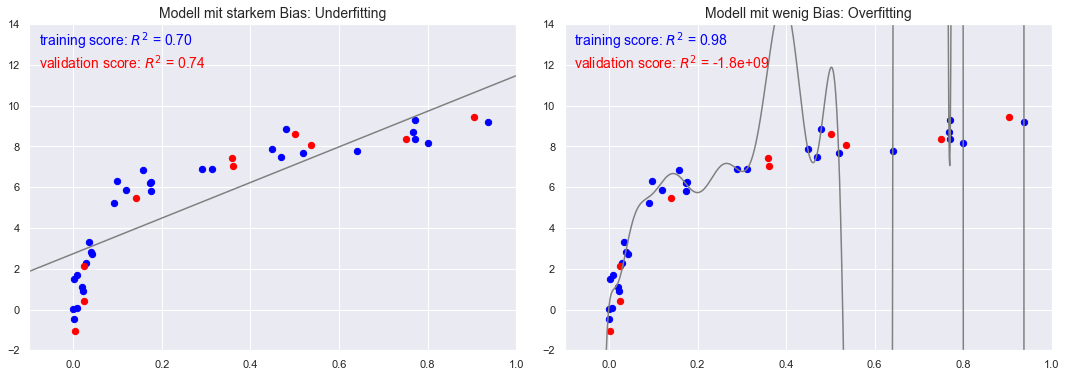

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('Modell mit starkem Bias: Underfitting', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('Modell mit wenig Bias: Overfitting', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red');

Allgemein gilt:

- Modelle mit starkem Bias: Performance auf Trainings- und Testdaten ist ähnlich.
- Modelle mit hoher Varianz: Performance auf Testdaten ist *deutlich* schlechter als auf den Trainingsdaten.

Extremfall: Modell kann einfach die Trainingsdaten auswendig lernen bzw. abspeichern. Damit kann ein Trainingsfehler von 0 erzeugt werden, der Generalisierungsfehler ist aber sehr hoch (vgl. einführendes Papaya-Beispiel).

## Validierungskurven
Welche Modellklasse sollte man nun wählen?

Hier: Welcher Polynomgrad ist der "beste"?

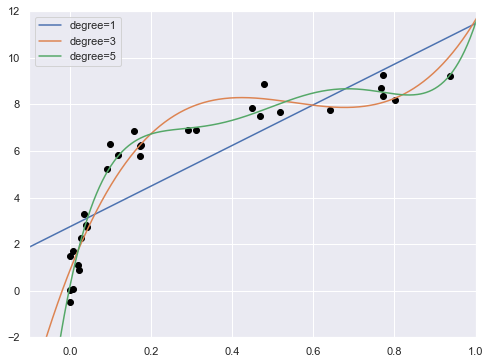

In [14]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.figure(figsize=(8,6))
plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Hier können wir die Modellkomplexität bzw. Modellkapazität kontrollieren, indem wir den Polynomgrad wählen.

**Höherer Polynomgrad:**
- Trainingsfehler wird kleiner, kann sogar auf 0 gebracht werden
- Generalisierungsfehler wird größer (Variance)

**Niedrigerer Polynomgrad:**
- Trainingsfehler wird größer
- Generalisierungsfehler wird ggf. kleiner

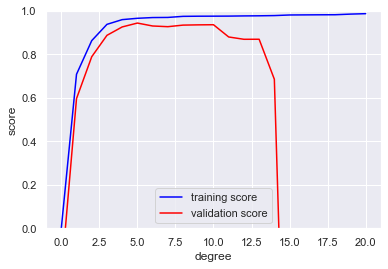

In [16]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve( PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Das Modell mit Grad 5 scheint hier am besten zu sein (da höchste Validation Score).

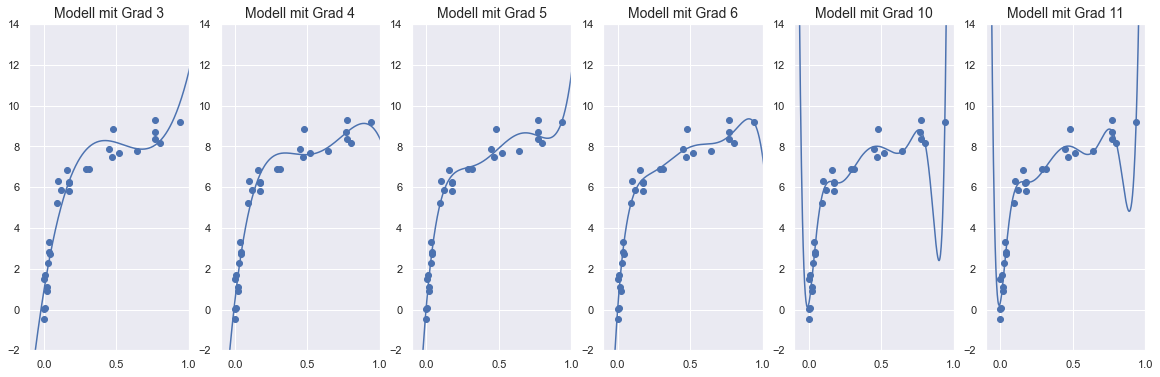

In [17]:
degrees = [3,4,5,6,10,11]
fig, ax = plt.subplots(1, len(degrees), figsize=(20, 6))
for i in range(len(degrees)):
  ax[i].scatter(X.ravel(), y)
  y_test = PolynomialRegression(degrees[i]).fit(X,y).predict(X_test)
  ax[i].plot(X_test.ravel(), y_test);
  ax[i].axis([-0.1, 1.0, -2, 14]);
  ax[i].set_title('Modell mit Grad {0}'.format(degrees[i]), size=14)

# Abhängigkeit von der Anzahl der Daten
Wie komplex ein Modell sein kann oder sein sollte, hängt auch von der Größe der Menge der Trainingsdaten ab.

## Versuch: Mehr Trainingsdaten
Wir generieren nun fünf mal soviele Trainingsdaten wie zuvor (200 statt 40):

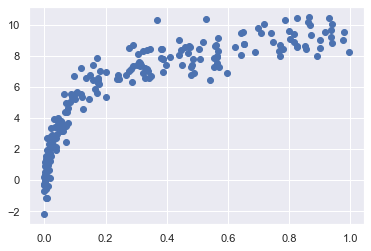

In [18]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

Damit ergeben sich folgende Validierungskurven. Die Validierungskurven des gleichen Modells mit nur 40 Trainingsdaten von oben sind gestrichelt dargestellt:

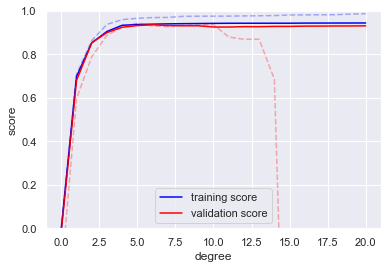

In [20]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Mit dieser größeren Menge an Trainingsdaten kann also ein komplexeres Modell trainiert werden. Das Optimum der Validation Score liegt in etwa bei Grad 6, aber auch Grad 20 wird keine wirkliches Overfitting erzeugen.

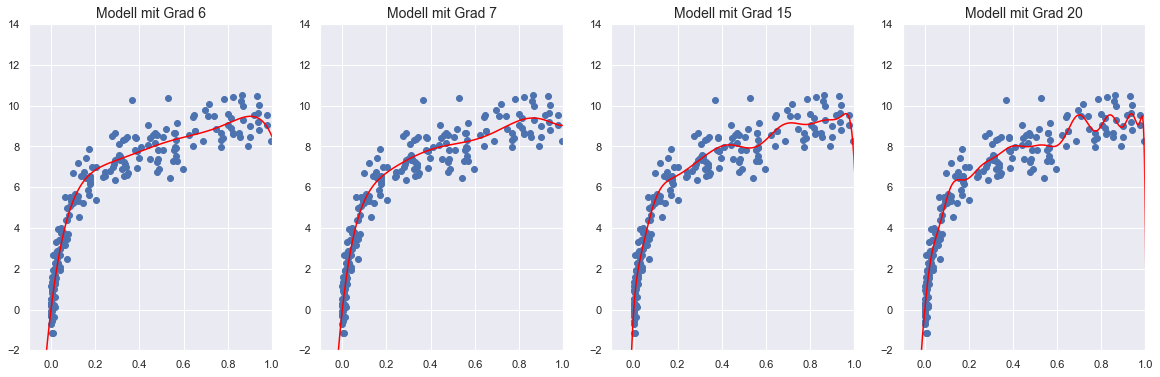

In [21]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
degrees = [6,7,15,20]
fig, ax = plt.subplots(1, len(degrees), figsize=(20, 6))
for i in range(len(degrees)):
  ax[i].scatter(X2.ravel(), y2)
  y_test = PolynomialRegression(degrees[i]).fit(X2,y2).predict(X_test)
  ax[i].plot(X_test.ravel(), y_test, c='red');
  ax[i].axis([-0.1, 1.0, -2, 14]);
  ax[i].set_title('Modell mit Grad {0}'.format(degrees[i]), size=14)

## Abhängigkeit der Modellperformance
Neben der Modellkomplexität (*Kapazität*) scheint die Leistungsfähigkeit eines Modells auch von der Anzahl der Trainingsdaten abzuhängen. Diese Abhängigkeit wird in Form einer *Lernkurve* (*Leraning curve*) dargestellt. Diese zeigt die Trainings- bzw. Validation-Score in Abhängigkeit von der Anzahl der Trainingsdaten.

Erwartetes Verhalten:

- Eine Modell von gegebener Komplexität wird ein kleines Trainingsset *overfitten*: hohe Trainings Score, deutlich niedrigere Validation Score
- Ein Modell von gegebener Komplexität wird ein großes Trainingsset *underfitten*: Trainings Score nimmt ab, Validation Score nimmt zu (wenn mehr Trainingsdaten hinzugefügt werden)
- Die Validation Score wird immer schlechter sein als die Trainings Score (abgesehen von Zufällen)

Die beiden Scores werden also für ein festes Modell gegeneinander konvergieren (für wachsende Anzahl an Trainingsdaten). Insbesondere wird die Score (und damit das Modell) irgendwann nicht mehr durch Hinzufügen weiterer Trainingsdaten verbessert werden. Dann muss die Modellkomplexität erhöht werden.

### Plot einer Lernkurve

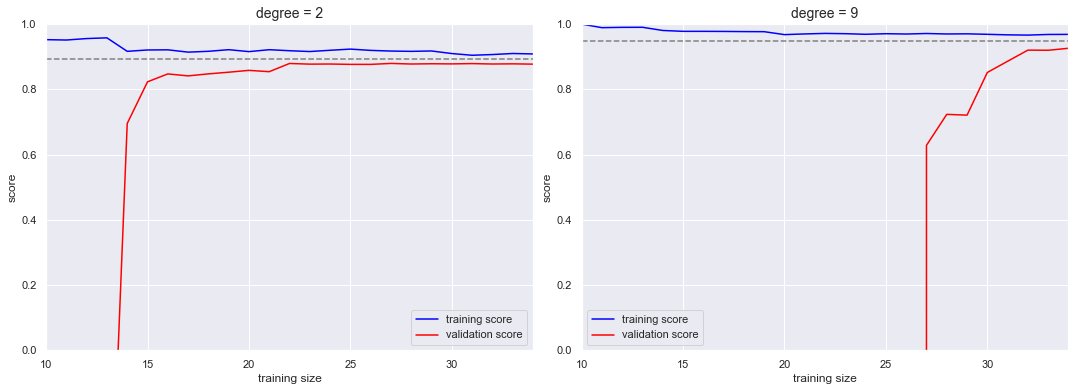

In [22]:
from sklearn.model_selection import learning_curve
X,y = make_data(N=40)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Beobachtungen:

- Hinzufügen weiterer Daten verbessert das kleine Modell (links) nicht.
- Wenn man mehr Trainingsdaten hat, kann man allerdings ein größeres Modell (rechts) verwenden. Dieses hat eine höhere "Grenz-Score" als das kleinere Modell (siehe Lage der gestrichelten Linie).